<a href="https://colab.research.google.com/github/flohmannjr/TCC530/blob/main/TCC530_Reprodu%C3%A7%C3%A3o_CFN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#TCC530 - Reprodução CFN

##Importações de bibliotecas

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import random

import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers

from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

##Configurações

In [2]:
plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 100

sns.set_style("darkgrid")

### Constantes

In [3]:
SEMENTE = 2008193

##Funções

In [4]:
class DCNN(tf.keras.Model):

  # Construtor da classe com passagem de parâmetros
  def __init__(self,
               vocab_size,    # Tamanho do vocabulário
               emb_dim,       # Tamanho da matriz de embbedings
               nb_filters,    # Número de filtros por região
               ffn_units,     # Feedforward - Número de neuronios da Rede neural densa
               dropout_rate,  # Zera percentual de neurônios para evitar overfetting
               training=True,
               name="dcnn"):

    super(DCNN, self).__init__(name=name)

    self.embedding = layers.Embedding(vocab_size, emb_dim)  # Gera matriz de palavras

    self.bigram   = layers.Conv1D(filters=nb_filters, kernel_size=2, padding='same', activation='relu')  # Gera os filtros de tamanho 2
    self.trigram  = layers.Conv1D(filters=nb_filters, kernel_size=3, padding='same', activation='relu')  # Gera os filtros de tamanho 3
    self.fourgram = layers.Conv1D(filters=nb_filters, kernel_size=4, padding='same', activation='relu')  # Gera os filtros de tamanho 4

    self.pool = layers.GlobalMaxPool1D()  # Etapa de maxpooling

    self.dense_1 = layers.Dense(units=ffn_units, activation='relu')  # Rede neural densa com ffn_unit definindo o numero de neuronios e função de ativação relu

    self.dropout = layers.Dropout(rate=dropout_rate)  # Passagem do parametro de dropout para evitar overfetting

    self.last_dense = layers.Dense(units=1, activation='sigmoid')  # Define a camada de saída com 1 bit e função de ativação sigmoid

  # Função que faz a "conexão" dos objetos da rede
  def call(self, inputs, training):

    x = self.embedding(inputs)  # Matriz de palavras recebe o texto

    x_1 = self.bigram(x)  # Filtros da região 3 recebem a matriz de palavras (região 3?)
    x_1 = self.pool(x_1)  # Executa o maxpooling no bigram

    x_2 = self.trigram(x)  # Filtros da região 2 recebem a matriz de palavras
    x_2 = self.pool(x_2)   # Executa o maxpooling no trigram

    x_3 = self.fourgram(x)  # Filtros da região 2 recebem a matriz de palavras (região 2?)
    x_3 = self.pool(x_3)    # Executa o maxpooling no fourgram

    merged = tf.concat([x_1, x_2, x_3], axis = -1)  # Faz a concatenação após o max pooling
    merged = self.dense_1(merged)                   # A camada primeira camada densa recebe o vetor concatenado
    merged = self.dropout(merged, training)         # Zera uma porção dos neurônios

    output = self.last_dense(merged)  # Liga a camada de dropout a camada de saída

    return output

def grafico_historico_por_iteracao(historico):

    for chave in historico.history.keys():
        sns.lineplot(data=historico.history[chave], label=chave)

    plt.title('Histórico por iteração')
    plt.xlabel('Iteração')
    plt.ylabel('')

    plt.legend(frameon=True, facecolor='white')
    plt.show()

def avaliar_modelo(validacao, previsao, rotulos=None, cmap='summer_r'):
    print(classification_report(validacao, previsao, target_names=rotulos))

    ConfusionMatrixDisplay.from_predictions(validacao, previsao, display_labels=rotulos, xticks_rotation='vertical', cmap=cmap)
    plt.grid(False)

    relatorio = classification_report(validacao, previsao, target_names=rotulos, output_dict=True)

    return {'acuracia': relatorio['accuracy'],
            'precisao': relatorio['weighted avg']['precision'],
            'revocacao': relatorio['weighted avg']['recall'],
            'pontuacao-f1': relatorio['weighted avg']['f1-score']}

##Dados

Fake.Br Corpus https://github.com/roneysco/Fake.br-Corpus

In [5]:
dados = pd.read_csv('https://raw.githubusercontent.com/roneysco/Fake.br-Corpus/master/preprocessed/pre-processed.csv',
                    index_col=['index'])

In [6]:
dados['label'].replace({'fake': 0, 'true': 1}, inplace=True)

In [7]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7200 entries, 0 to 7199
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   label              7200 non-null   int64 
 1   preprocessed_news  7200 non-null   object
dtypes: int64(1), object(1)
memory usage: 168.8+ KB


In [8]:
dados

,label,preprocessed_news
index,,
0,0,katia abreu diz vai colocar expulsao moldura n...
1,0,ray peita bolsonaro conservador fake entrevist...
2,0,reinaldo azevedo desmascarado policia federal ...
3,0,relatorio assustador bndes mostra dinheiro pub...
4,0,radialista americano fala sobre pt vendem ilus...
...,...,...
7195,1,jornal britanico acao contra lula lava jato se...
7196,1,temer diz acionou pf cade investigar aumentos ...
7197,1,obstaculos politicos temer especialistas ouvid...


In [9]:
dados['label'].value_counts()

0    3600
1    3600
Name: label, dtype: int64

In [10]:
X = dados['preprocessed_news']
y = dados['label']

### Tokenização

In [11]:
%%time

tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(X, target_vocab_size=60000)

CPU times: user 2min 16s, sys: 1.29 s, total: 2min 17s
Wall time: 2min 26s


In [12]:
tokenizer.vocab_size

57046

In [13]:
# print(tokenizer.subwords)

In [14]:
data_inputs = [tokenizer.encode(sentence) for sentence in X]

In [15]:
for _ in range(10):
    print(data_inputs[random.randint(0, len(data_inputs) - 1)])

[5509, 10355, 12831, 8451, 22408, 732, 1214, 533, 4101, 493, 306, 94, 6139, 262, 238, 2208, 8587, 2702, 373, 12498, 955, 211, 18632, 2593, 898, 769, 933, 3048, 955, 234, 268, 105, 4340, 10466, 5743, 3469, 10319, 203, 769, 207, 5929, 1220, 18357, 4307, 5509, 3319, 12831, 562, 238, 8606, 29521, 15073, 1356, 17415, 277, 821, 10627, 1506, 13148, 21512, 530, 6902, 916, 10627, 13770, 1214, 821, 18357, 8587, 3, 119, 42300, 2009, 3363, 44526, 18984, 3182, 21512, 35, 319, 1741, 728, 27, 3490, 4500, 5126, 7, 493, 2415, 10356, 410, 52593]
[469, 2853, 4675, 2737, 2853, 4675, 265, 488, 5730, 175, 56, 12079, 292, 1, 287, 727, 1003, 4675, 7682, 189, 157, 42449, 24769, 7290, 531, 120, 2, 40, 2268, 9636, 209, 2900, 44, 1270, 9266, 208, 4, 5095, 4247, 486, 2853, 4675, 10, 2907, 241, 187, 282, 6389, 22, 105, 1397, 469, 8, 505, 56076, 14585]
[3049, 778, 477, 5023, 1443, 27111, 3263, 6179, 1181, 3049, 4877, 1441, 326, 228, 615, 477, 5023, 115, 3410, 20, 4877, 5324, 5048, 2877, 2865, 8643, 2334, 877, 3137, 

### Padding

In [16]:
max_len = max([len(sentence) for sentence in data_inputs])
max_len

4404

In [17]:
data_inputs = tf.keras.preprocessing.sequence.pad_sequences(data_inputs,
                                                            value=0,
                                                            padding='post',
                                                            maxlen=max_len)

In [18]:
for _ in range(10):
    print(data_inputs[random.randint(0, len(data_inputs) - 1)])

[959 723  17 ...   0   0   0]
[ 4217   663  8045 ...  2012     4 11705]
[   77 11360    63 ...     0     0     0]
[5528 7006 2174 ...    0    0    0]
[ 3653 12198   777 ...     0     0     0]
[  10  418 9812 ...    0    0    0]
[ 5337  2401 21822 ...     0     0     0]
[ 4098 38307 20017 ...     0     0     0]
[14788 31117  6853 ...     0     0     0]
[ 475 1475 1057 ...    0    0    0]


### Separação

In [19]:
X_train, X_test, y_train, y_test = train_test_split(data_inputs,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=SEMENTE)

In [20]:
X_train = X_train.astype(np.int64)
X_test  = X_test.astype(np.int64)
y_train = y_train.astype(np.int64)
y_test  = y_test.astype(np.int64)

In [21]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5760, 4404), (1440, 4404), (5760,), (1440,))

In [22]:
X_train.dtype, X_test.dtype, y_train.dtype, y_test.dtype

(dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'))

##Modelo

In [23]:
dcnn = DCNN(vocab_size=tokenizer.vocab_size,
            emb_dim=128,
            nb_filters=50,
            ffn_units=512,
            dropout_rate=0.1)

In [24]:
dcnn.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [25]:
%%time

historico = dcnn.fit(x=X_train,
                     y=y_train,
                     batch_size=64,
                     epochs=5,
                     validation_data=(X_test, y_test),
                     verbose=1)

Epoch 1/5
90/90 [==============================] - 37s 259ms/step - loss: 0.3515 - accuracy: 0.8293 - val_loss: 0.1040 - val_accuracy: 0.9590
Epoch 2/5
90/90 [==============================] - 22s 239ms/step - loss: 0.0629 - accuracy: 0.9802 - val_loss: 0.1203 - val_accuracy: 0.9556
Epoch 3/5
90/90 [==============================] - 22s 243ms/step - loss: 0.0095 - accuracy: 0.9988 - val_loss: 0.0886 - val_accuracy: 0.9632
Epoch 4/5
90/90 [==============================] - 22s 247ms/step - loss: 0.0016 - accuracy: 0.9998 - val_loss: 0.0862 - val_accuracy: 0.9667
Epoch 5/5
90/90 [==============================] - 21s 229ms/step - loss: 6.2505e-04 - accuracy: 1.0000 - val_loss: 0.0903 - val_accuracy: 0.9653
CPU times: user 1min 21s, sys: 2.62 s, total: 1min 23s
Wall time: 2min 3s


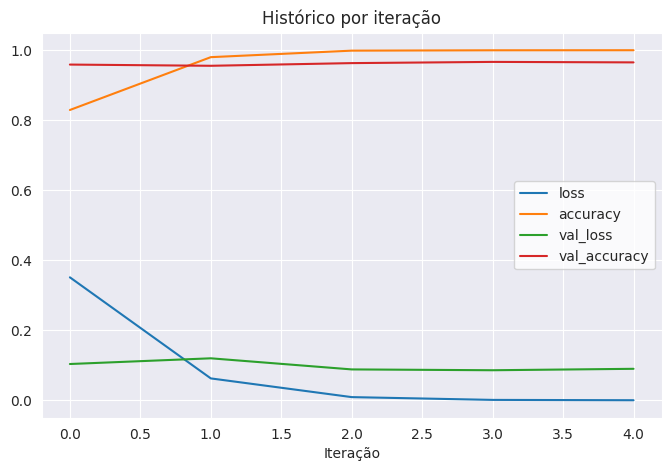

In [26]:
grafico_historico_por_iteracao(historico)

45/45 [==============================] - 1s 16ms/step
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       720
           1       0.98      0.95      0.96       720

    accuracy                           0.97      1440
   macro avg       0.97      0.97      0.97      1440
weighted avg       0.97      0.97      0.97      1440



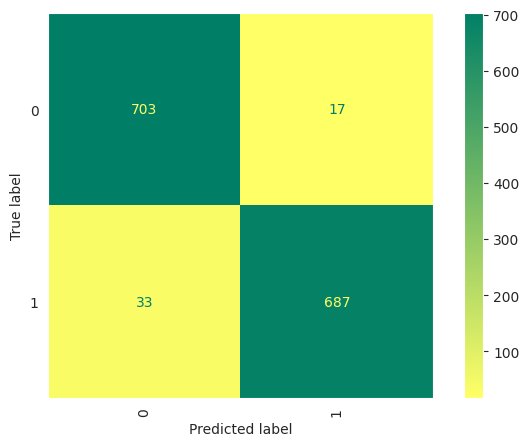

In [27]:
# avaliacao      = dcnn.evaluate(X_test, y_test)
probabilidades = dcnn.predict(X_test)
previsoes      = tf.squeeze(tf.round(probabilidades))
relatorio      = avaliar_modelo(y_test, previsoes)

In [28]:
relatorio

{'acuracia': 0.9652777777777778,
 'precisao': 0.9655076581027668,
 'revocacao': 0.9652777777777778,
 'pontuacao-f1': 0.9652734905543895}